<a href="https://colab.research.google.com/github/mingder78/500pxAPITemplateForiOS/blob/master/4Groups_DEGs_gsea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, pearsonr, f_oneway
import numpy as np

# Step 2: Load data
## Expression data: the rows are meta data and gene exression p-value, columns are samples

## optional files (with different sizes)
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output.csv
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output-11-lines.csv
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output-101-lines.csv
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output-201-lines.csv

## datatset source
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62564/matrix/

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output.csv", index_col=0)
df = df[df["mycn_status"].isin(["mycn_amp", "mycn_nonamp"])].copy()
df_clean = df[df["high_risk"].isin(["yes", "no"])].copy()

# Step 2.1: Separate metadata and expression matrix

In [ ]:
metadata = df_clean.iloc[:, :17]      # Adjust this to match metadata column count
expression = df_clean.iloc[:, 17:]    # Everything after metadata is gene expression
metadata = metadata.drop(columns=["id"])

expression.to_csv("expression_matrix.tsv", sep="\t", header=True)
metadata.to_csv("clinical_data.tsv", sep="\t", header=True)

In [ ]:
# Check the result
print("Metadata preview:\n", metadata.head())
print("Expression preview:\n", expression.head())

Metadata preview:
             age_at_diagnosis    d_fav_all data set death_from_disease  \
gene                                                                    
gsm1205238             987.0  unfavorable      all                yes   
gsm1205239            1808.0  unfavorable      all                yes   
gsm1205240             625.0  unfavorable      all                yes   
gsm1205241             335.0           nd      all                 no   
gsm1205242             536.0  unfavorable      all                yes   

             efs_bin  efs_day geo_id_rnaseq high_risk inss_stage  mycn_status  \
gene                                                                            
gsm1205238     event      593    gsm1528894       yes        st4  mycn_nonamp   
gsm1205239     event     2016    gsm1528895       yes        st4  mycn_nonamp   
gsm1205240     event      840    gsm1528896       yes        st4     mycn_amp   
gsm1205241  no_event     2046    gsm1528897       yes        st2

In [ ]:
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

# === 1. 讀取表現資料與臨床資料 ===
expr = pd.read_csv("expression_matrix.tsv", sep="\t", index_col=0) # rows=genes, cols=samples
meta = pd.read_csv("clinical_data.tsv", sep="\t", index_col=0)

In [ ]:
expr = expr.T

In [ ]:

# === 2. 定義自訂的 4 群 ===
# 假設臨床資料中有 'mycn_status' 和 'high_risk'
def classify(col):
    if col['mycn_status'] == 'mycn_amp' and col['high_risk'] == 'yes':
        return 'HH'
    elif col['mycn_status'] == 'mycn_amp' and col['high_risk'] == 'no':
        return 'HL'
    elif col['mycn_status'] == 'mycn_nonamp' and col['high_risk'] == 'yes':
        return 'LH'
    elif col['mycn_status'] == 'mycn_nonamp' and col['high_risk'] == 'no':
        return 'LL'
    else:
        return None

meta['group'] = meta.apply(classify, axis=1)
meta = meta[meta['group'].notnull()]  # 移除不完整資料

In [ ]:

# === 3. 多群組統計檢定 (ANOVA) ===
groups = meta['group'].unique()
results = []

for gene in expr.index:
    # 抓每一組的表現值
    values = [expr.loc[gene, meta[meta['group'] == g].index] for g in groups]
    stat, pval = f_oneway(*values)
    results.append((gene, pval))

# === 4. 多重比較校正 (FDR) ===
res_df = pd.DataFrame(results, columns=["Gene", "pval"])
res_df["adj_pval"] = smm.multipletests(res_df["pval"], method="fdr_bh")[1]
res_df = res_df.sort_values("adj_pval")

# 很明顯, MYCN 基因表達關聯性很高

In [ ]:
res_df

,Gene,pval,adj_pval
10772,MYCN,1.033036e-119,1.995826e-115
11941,PAICS,6.200389e-80,3.993050e-76
14224,RPL22L1,4.572839e-80,3.993050e-76
418,AHCY,3.937936e-79,1.902023e-75
8966,LINC00839,3.945065e-72,1.524373e-68
...,...,...,...
9688,LSAMP,9.901587e-01,9.903637e-01
8104,KCNJ11,9.911346e-01,9.912885e-01
18606,ZBTB26,9.941435e-01,9.942465e-01
10071,MDM4,9.962741e-01,9.963257e-01


In [ ]:
# === 6. 篩選顯著 DEG ===
deg = res_df[(res_df["adj_pval"] < 5e-50)]


In [ ]:
first_top_list_gene = deg['Gene'].tolist()

In [ ]:
if ('MYCN' in first_top_list_gene):
    print("MYCN in the top list genes")

MYCN in the top list genes


In [ ]:
filtered_expr = expr.loc[expr.index.isin(first_top_list_gene)]

# Step 3: Normalize / scale expression data

In [ ]:
expression_data = filtered_expr
expression_data
metadata = meta

In [ ]:
expression = expression_data.T

# 因為太多基因, 我們用 PCA 降維, 分 20組

In [ ]:
n_pc = 20 #need to change for different sample size 10 ~ 40

In [ ]:
scaler = StandardScaler()
scaled_expr = scaler.fit_transform(expression)

pca = PCA(n_components=n_pc)
pcs = pca.fit_transform(scaled_expr)

pca_df = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(pcs.shape[1])], index=expression.index)
pca_df = pca_df.join(metadata)

In [ ]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,high_risk,inss_stage,mycn_status,os_bin,os_day,progression,seqc_id,sex,train_valid_set,group
gene,,,,,,,,,,,,,,,,,,,,,
gsm1205238,-0.704624,-1.409017,-0.415086,0.166715,0.158600,1.790961,0.303098,0.832294,-0.795751,-0.555124,...,yes,st4,mycn_nonamp,event,1362,yes,seqc_nb001,m,training,LH
gsm1205239,0.316792,-0.660441,0.416245,-0.164678,0.204371,4.096136,-0.967461,-0.287489,0.473779,0.114688,...,yes,st4,mycn_nonamp,event,2836,yes,seqc_nb002,m,validation,LH
gsm1205240,7.571630,-1.524693,1.844487,-1.797825,0.425462,0.039004,0.658837,-0.037186,-0.018844,0.432582,...,yes,st4,mycn_amp,event,1191,yes,seqc_nb003,f,training,HH
gsm1205241,2.978350,-1.278737,1.494718,0.274381,-0.996566,-0.270943,-0.319778,-1.376180,0.059269,0.198963,...,yes,st2,mycn_amp,no_event,2046,no,seqc_nb004,f,validation,HH
gsm1205242,6.745596,-1.735026,2.765741,-1.377450,0.044062,-0.076266,-1.032634,-0.035185,0.174151,0.243148,...,yes,st4,mycn_amp,event,220,yes,seqc_nb005,f,training,HH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gsm1205731,-2.819370,-0.584104,0.109406,-0.220818,-0.080255,-0.283178,0.354033,0.058371,-0.072227,-0.372359,...,no,st1,mycn_nonamp,no_event,4828,no,seqc_nb494,m,validation,LL
gsm1205732,-2.358316,1.701310,-0.053317,0.149960,-0.236282,-0.544390,0.157453,-0.430546,0.184108,0.199199,...,no,st1,mycn_nonamp,no_event,2467,no,seqc_nb495,m,training,LL
gsm1205733,-1.497211,-0.422295,-1.177922,-0.137041,0.712605,0.054930,-0.118991,0.123438,-0.467507,0.226688,...,no,st1,mycn_nonamp,no_event,5780,yes,seqc_nb496,m,validation,LL


#✅ 2. Test correlation between each PC and each metadata variable

## Here’s a flexible function that does this for both:

* categorical metadata (via t-tests or ANOVA)
* numerical metadata (via Pearson correlation)


In [ ]:
# create correlate_pcs_with_metadata function
def correlate_pcs_with_metadata(pca_df, metadata_columns, max_pc=10):
    results = []

    for pc in [f"PC{i+1}" for i in range(max_pc)]:
        for col in metadata_columns:
            values = pca_df[col].dropna()
            pc_values = pca_df.loc[values.index, pc]

            if pd.api.types.is_numeric_dtype(values):
                # Continuous variable → Pearson correlation
                if len(pc_values) >= 2 and len(values) >= 2:
                    r, p = pearsonr(pc_values, values)
                    results.append((pc, col, "correlation", r, p))
                else:
                    print(f"Skipping {pc} and {col} due to insufficient data points.")
            else:
                groups = [pc_values[values == lvl] for lvl in values.unique()]
                if len(groups) == 2:
                    stat, p = ttest_ind(groups[0], groups[1])
                    results.append((pc, col, "t-test", stat, p))
                elif len(groups) > 2:
                    stat, p = f_oneway(*groups)
                    results.append((pc, col, "ANOVA", stat, p))
                else:
                    continue  # Skip degenerate variables

    return pd.DataFrame(results, columns=["PC", "Metadata", "Test", "Statistic", "P-value"]).sort_values("P-value")


In [ ]:
metadata_columns = metadata.columns.tolist()
correlation_results = correlate_pcs_with_metadata(pca_df, metadata_columns, max_pc=10)
print(correlation_results.head(10))

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:580: SmallSampleWarning:

all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.

<ipython-input-622-fd0f93b41d71>:23: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



     PC            Metadata         Test   Statistic        P-value
15  PC1               group        ANOVA  589.661185  3.764327e-131
8   PC1         mycn_status       t-test  -32.682832  2.774792e-125
6   PC1           high_risk       t-test   18.756429   1.378304e-59
1   PC1           d_fav_all        ANOVA  100.039492   3.696863e-37
9   PC1              os_bin       t-test   12.168051   5.897183e-30
2   PC1  death_from_disease       t-test   12.168051   5.897183e-30
7   PC1          inss_stage        ANOVA   29.638283   4.384128e-22
3   PC1             efs_bin       t-test    9.513144   8.299305e-20
11  PC1         progression       t-test    9.513144   8.299305e-20
10  PC1              os_day  correlation   -0.380899   1.809281e-18


# filter out p-value < 0.05



In [ ]:
significant_results = correlation_results[correlation_results["P-value"] < 0.05]
significant_results

,PC,Metadata,Test,Statistic,P-value
15,PC1,group,ANOVA,589.661185,3.764327e-131
8,PC1,mycn_status,t-test,-32.682832,2.774792e-125
6,PC1,high_risk,t-test,18.756429,1.378304e-59
1,PC1,d_fav_all,ANOVA,100.039492,3.696863e-37
9,PC1,os_bin,t-test,12.168051,5.897183e-30
...,...,...,...,...,...
49,PC4,d_fav_all,ANOVA,3.313034,3.722280e-02
129,PC9,d_fav_all,ANOVA,3.173190,4.273159e-02
145,PC10,d_fav_all,ANOVA,3.054690,4.803603e-02
34,PC3,death_from_disease,t-test,-1.965775,4.988772e-02


# ✅ What above results say:
## PC3 is strongly associated with high_risk, mycn_status, d_fav_all, and several clinical features.

## PC2 and PC1 also relate to survival (e.g., os_day, efs_day), indicating different biological axes.

# 🧬 1. Get Top Genes by PCA Loadings

# The following Scree Plot
## tells you how much of the total variance each PC captures.




# PC 與 mycn_status 以及 d_fav_all 都有顯著相關性


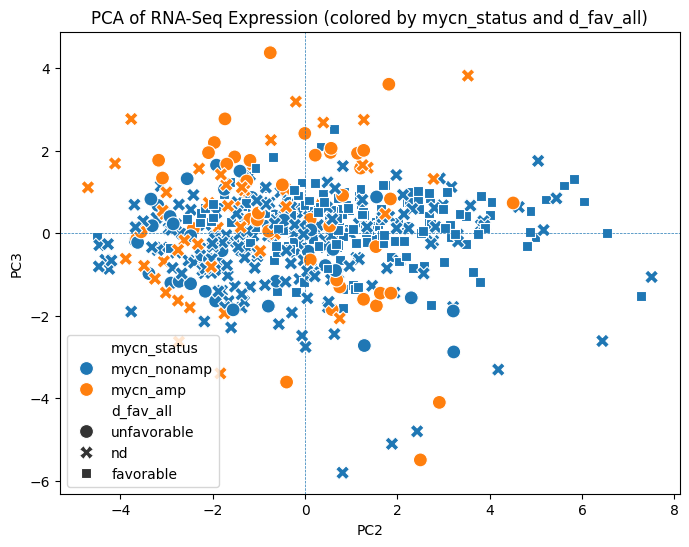

In [ ]:
# Step 5: Plot PCA colored by MYCN status
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC2", y="PC3", hue="mycn_status", style="d_fav_all", s=100)
plt.title("PCA of RNA-Seq Expression (colored by mycn_status and d_fav_all)")
plt.axhline(0, ls="--", lw=0.5)
plt.axvline(0, ls="--", lw=0.5)
plt.show()

# 📈 Optional: Show explained variance


## To decide how many PCs are useful:
* explained_var.cumsum() up to 80% - 90%

In [ ]:
explained_var = pca.explained_variance_ratio_
print("Explained variance:", explained_var)
print("Cumulative:", explained_var.cumsum())

Explained variance: [0.57852036 0.12554148 0.03672713 0.02295844 0.01939314 0.01807582
 0.01623581 0.0148545  0.01266108 0.01169519 0.01136392 0.00992395
 0.00965676 0.00885774 0.0080208  0.00769824 0.00743133 0.00671631
 0.00657565 0.00610532]
Cumulative: [0.57852036 0.70406184 0.74078897 0.7637474  0.78314054 0.80121636
 0.81745217 0.83230667 0.84496775 0.85666294 0.86802686 0.87795082
 0.88760758 0.89646532 0.90448612 0.91218435 0.91961569 0.926332
 0.93290765 0.93901297]


# If a PC explains <1% of variance, it's likely unimportant.

# explained_var.cumsum() better up to 80%

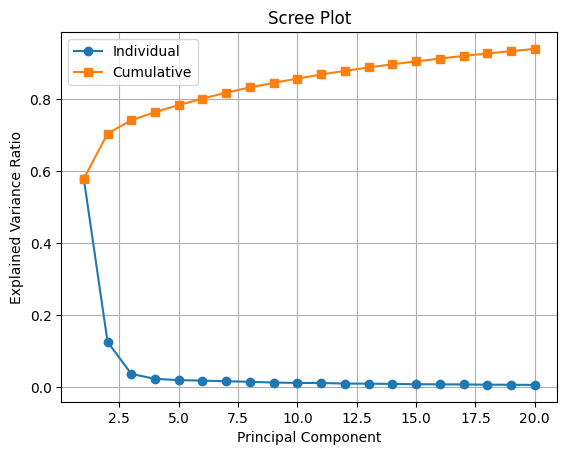

In [ ]:
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label='Individual')
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='s', label='Cumulative')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.legend()
plt.grid(True)
plt.show()

# Auto test PCs to find associations

# ✅ Helper: Test PC–Metadata Associations
## example:
* metadata_fields = ["mycn_status", "high_risk", "os_day", "inss_stage", "d_fav_all"]
* metadata_fields = ["mycn_status", "d_fav_all", "age_at_diagnosis", "death_from_disease", 	"efs_bin", 	"efs_day" ,"high_risk" , "inss_stage", 	"os_bin", "os_day", "progression" ,	"sex", 	"train_valid_set"]


In [ ]:

from scipy.stats import ttest_ind, f_oneway, pearsonr
from sklearn.preprocessing import LabelEncoder

def test_pc_metadata_associations(pca_df, metadata_fields, n_pcs=5):
    """
    Automatically test association between the top N PCs and metadata fields.
    Works for binary, categorical, and numeric metadata.

    Parameters:
    - pca_df: DataFrame with PC columns and metadata joined (PC1, PC2, ..., plus metadata columns)
    - metadata_fields: list of metadata column names
    - n_pcs: number of PCs to test (default=5)

    Prints p-values of association tests.
    """
    results = []

    for field in metadata_fields:
        values = pca_df[field]

        for pc in [f"PC{i+1}" for i in range(n_pcs)]:
            pc_values = pca_df[pc]

            if values.nunique() == 2:
                # Binary field: use t-test
                groups = [pc_values[values == v] for v in values.unique()]
                stat, pval = ttest_ind(*groups, equal_var=False)
                test = "t-test"
            elif values.dtype.kind in "if":  # numeric field
                # Use Pearson correlation
                stat, pval = pearsonr(pc_values, values)
                test = "Pearson"
            else:
                # Categorical with >2 groups: use ANOVA
                groups = [pc_values[values == v] for v in values.unique()]
                stat, pval = f_oneway(*groups)
                test = "ANOVA"

            results.append({
                "PC": pc,
                "Metadata": field,
                "Test": test,
                "P-Value": pval
            })

    results_df = pd.DataFrame(results).sort_values("P-Value")
    #display(results_df)
    return results_df


In [ ]:
metadata_fields = ["mycn_status", "d_fav_all", "age_at_diagnosis", "death_from_disease", 	"efs_bin", 	"efs_day" ,"high_risk" , "inss_stage", 	"os_bin", "os_day", "progression" ,	"sex"]
#metadata_fields = ["mycn_status", "high_risk", "os_day", "inss_stage", "d_fav_all"]
test_pc_metadata_associations(pca_df, metadata_fields, n_pcs=4)


,PC,Metadata,Test,P-Value
0,PC1,mycn_status,t-test,1.352323e-38
4,PC1,d_fav_all,ANOVA,3.696863e-37
24,PC1,high_risk,t-test,6.350732e-33
28,PC1,inss_stage,ANOVA,4.384128e-22
36,PC1,os_day,Pearson,1.809281e-18
29,PC2,inss_stage,ANOVA,1.373518e-17
32,PC1,os_bin,t-test,2.829219e-16
12,PC1,death_from_disease,t-test,2.829219e-16
25,PC2,high_risk,t-test,4.472752e-16
20,PC1,efs_day,Pearson,6.936641e-16


# Select how many top genes (top_n) need to be inspect for each PC

In [ ]:
top_n = 10 # 50 ~ 1000
# genes = columns in expression matrix
gene_names = expression.columns
components = pd.DataFrame(pca.components_, columns=gene_names, index=[f"PC{i+1}" for i in range(pca.n_components)])

# Create a dict of top N genes (by absolute loading) per PC
top_genes_by_pc = {}

for pc in components.index:
    loadings = components.loc[pc]
    top_genes = loadings.abs().sort_values(ascending=False).head(top_n).index
    top_genes_by_pc[pc] = loadings[top_genes].sort_values(ascending=False)  # signed values

# Example: show top 10 genes for PC1

list_of_pc = [f"PC{i+1}" for i in range(pca.n_components)]
#list_of_pc = ['PC3']

def print_top_genes(list_of_pc):
    for pc in list_of_pc:
        print(f"Top genes for {pc}:")
        x = top_genes_by_pc[pc].index.tolist()
        print(x)
        if ('MYCN' in x):
            print("🎸🎸🎸🎸 MYCN in this top list genes")
        print()



In [ ]:
print_top_genes(list_of_pc)

Top genes for PC1:
['PAICS', 'AHCY', 'MYCN', 'NPM1', 'FBL', 'GMPS', 'RPL22L1', 'DCTPP1', 'TKT', 'EEF1B2']
🎸🎸🎸🎸 MYCN in this top list genes

Top genes for PC2:
['STX12', 'CAMTA1', 'PRKCZ', 'MFN2', 'ZCCHC17', 'TOM1L2', 'ARHGEF10L', 'PMP22', 'TKT', 'GPR125']

Top genes for PC3:
['VWCE', 'SLC38A5', 'MYOZ3', 'KLRG2', 'LINC00839', 'MYCN', 'SLCO4A1', 'TOM1L2', 'MPST', 'CDT1']
🎸🎸🎸🎸 MYCN in this top list genes

Top genes for PC4:
['MYOZ3', 'EEF1B2', 'SNHG1', 'RPL22L1', 'TRAP1', 'PUS7', 'PHGDH', 'ZNF695', 'KLRG2', 'SLCO4A1']

Top genes for PC5:
['VWCE', 'KLRG2', 'SNHG1', 'CDT1', 'FAM60A', 'DCTPP1', 'SLCO4A1', 'TRAP1', 'DCAF4', 'PHGDH']

Top genes for PC6:
['NCAN', 'ZNF695', 'MYOZ3', 'DCTPP1', 'ZCCHC17', 'PHGDH', 'MPST', 'KLRG2', 'RPL22L1', 'PMP22']

Top genes for PC7:
['SLC38A5', 'KLRG2', 'C19ORF48', 'SNHG1', 'MFN2', 'DCAF4', 'PUS7', 'GPR125', 'VWCE', 'CBS']

Top genes for PC8:
['KLRG2', 'HPDL', 'DCAF4', 'MYOZ3', 'MFN2', 'ZNF695', 'GPR125', 'PMP22', 'SNHG1', 'LINC00839']

Top genes for PC9:
['FA

# 🧪 2. Extract Expression Data for Top Genes

## expression_data shape: (genes, samples)
## If shape is (samples, genes), transpose first

In [ ]:
pc_name = 'PC3'

In [ ]:
top_genes = top_genes_by_pc[pc_name].index.tolist()
if ('MYCN' in top_genes):
    print("🚀 MYCN in the top list genes")

🚀 MYCN in the top list genes


In [ ]:
expression_data

gene,gsm1205238,gsm1205239,gsm1205240,gsm1205241,gsm1205242,gsm1205243,gsm1205244,gsm1205245,gsm1205246,gsm1205247,...,gsm1205726,gsm1205727,gsm1205728,gsm1205729,gsm1205730,gsm1205731,gsm1205732,gsm1205733,gsm1205734,gsm1205735
AHCY,24661.96,31651.80,52864.07,44146.15,45702.96,22073.08,18951.18,82379.63,50360.33,85284.74,...,52498.92,65991.84,26615.89,40342.14,16961.78,16158.44,20594.91,23493.92,18561.17,16844.62
ARHGEF10L,15076.35,17682.08,4904.87,8902.53,5367.37,21173.91,17805.06,9475.59,9541.50,7590.61,...,5480.15,4770.75,16270.83,6382.92,18951.18,21769.19,28526.20,22073.08,27364.16,18305.63
C19ORF48,4359.66,3565.78,6165.49,2836.70,3902.01,4420.52,2241.11,11585.24,3795.30,7486.11,...,7281.40,8422.31,3147.52,6517.03,2005.85,1499.22,2256.70,3304.01,2401.97,1097.50
CAMTA1,7750.10,14562.80,4039.61,8248.98,2836.70,15181.22,13587.57,3492.39,2256.70,4672.57,...,2149.82,1176.27,7281.40,2610.30,26987.43,13873.08,22693.63,14562.80,18951.18,11425.74
CBS,17682.08,26801.01,93975.69,57848.82,85284.74,23331.64,32768.00,131072.00,66913.05,97966.44,...,84110.60,41476.31,38165.99,63303.60,32768.00,24154.43,25531.67,21618.82,24154.43,8659.09
CDT1,16384.00,12854.63,23657.34,6562.36,10015.87,19082.99,5256.91,38165.99,17682.08,19755.96,...,28924.41,13587.57,12077.21,20738.16,9741.99,5042.77,8248.98,13493.72,6472.02,2876.30
DCAF4,2210.26,2076.59,4011.71,3666.02,4544.80,1951.00,1924.14,8079.22,2998.45,7434.40,...,4420.52,3743.05,2256.70,4672.57,1341.84,1686.71,2817.11,1652.00,2683.69,2521.38
DCTPP1,10297.45,15076.35,14164.58,13777.25,12503.12,8422.31,5007.94,25888.07,18820.27,20738.16,...,18690.27,18305.63,13034.07,12077.21,8192.00,7967.99,8480.89,7131.55,7131.55,6608.01
EEF1B2,70239.75,65083.31,138545.47,103552.30,142440.51,108700.57,61572.56,242899.50,108700.57,211456.30,...,150562.19,136638.07,62000.83,151609.43,59475.18,71220.26,80684.28,97966.44,77397.54,73731.83
FAM60A,5330.30,9280.58,11993.79,9345.14,12161.22,13034.07,6038.61,20171.07,12330.98,20452.65,...,14462.21,10441.20,5042.77,13493.72,4904.87,4737.80,8719.32,8719.32,5673.41,5077.84


In [ ]:
top_genes

['VWCE',
 'SLC38A5',
 'MYOZ3',
 'KLRG2',
 'LINC00839',
 'MYCN',
 'SLCO4A1',
 'TOM1L2',
 'MPST',
 'CDT1']

In [ ]:
expr_top_genes = expression_data.loc[top_genes]  # genes x samples
expr_top_genes = expr_top_genes.T  # samples x genes

#🧷 3. Add Metadata (e.g., d_fav_all)

## Assume metadata has sample IDs as index matching expr_top_genes


 # target_field can be any of bellow, need binary or yes and no
 > metadata_fields = ["mycn_status", "d_fav_all", "age_at_diagnosis", "death_from_disease", 	"efs_bin", 	"efs_day" ,"high_risk" , "inss_stage", 	"os_bin", "os_day", "progression" ,	"sex"]

 ## # if you change target_field, need to change following 'yes' or 'no' to your new field status


# for testing only

In [ ]:
#target_field = 'mycn_status' or 'high_risk', etc. status
target_field = 'efs_bin'
expr_with_meta = expr_top_genes.copy()
expr_with_meta[target_field] = metadata.loc[expr_top_genes.index, target_field]
expr_with_meta[target_field]

,efs_bin
gene,
gsm1205238,event
gsm1205239,event
gsm1205240,event
gsm1205241,no_event
gsm1205242,event
...,...
gsm1205731,no_event
gsm1205732,no_event
gsm1205733,event


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create row colors based on `high_risk` or others target_field status
## if you change target_field, need to change following 'yes' or 'no' to your new field status

#🔥 4. Plot Heatmap with Clustering


# 🚀 Heatmap for top genes (groups) associate to high_risk (in PC3)




In [ ]:
def plot_heatmap_for_pc(target_field, red, blue):
  expr_with_meta = expr_top_genes.copy()
  expr_with_meta[target_field] = metadata.loc[expr_top_genes.index, target_field]
  row_colors = expr_with_meta[target_field].map({
    red: 'red',
    blue: 'blue'
  }) if target_field in expr_with_meta.columns else None

  # Drop metadata for clustering
  data_only = expr_with_meta.drop(columns=[target_field])

  # Plot
  sns.clustermap(
    data_only,
    row_colors=row_colors,
    cmap="vlag",
    standard_scale=1,  # normalize per gene
    figsize=(12, 10),
    xticklabels=True,
    yticklabels=False
  )
  plt.title(f'Heatmap of Top {top_n} {pc_name} Genes')
  plt.show()


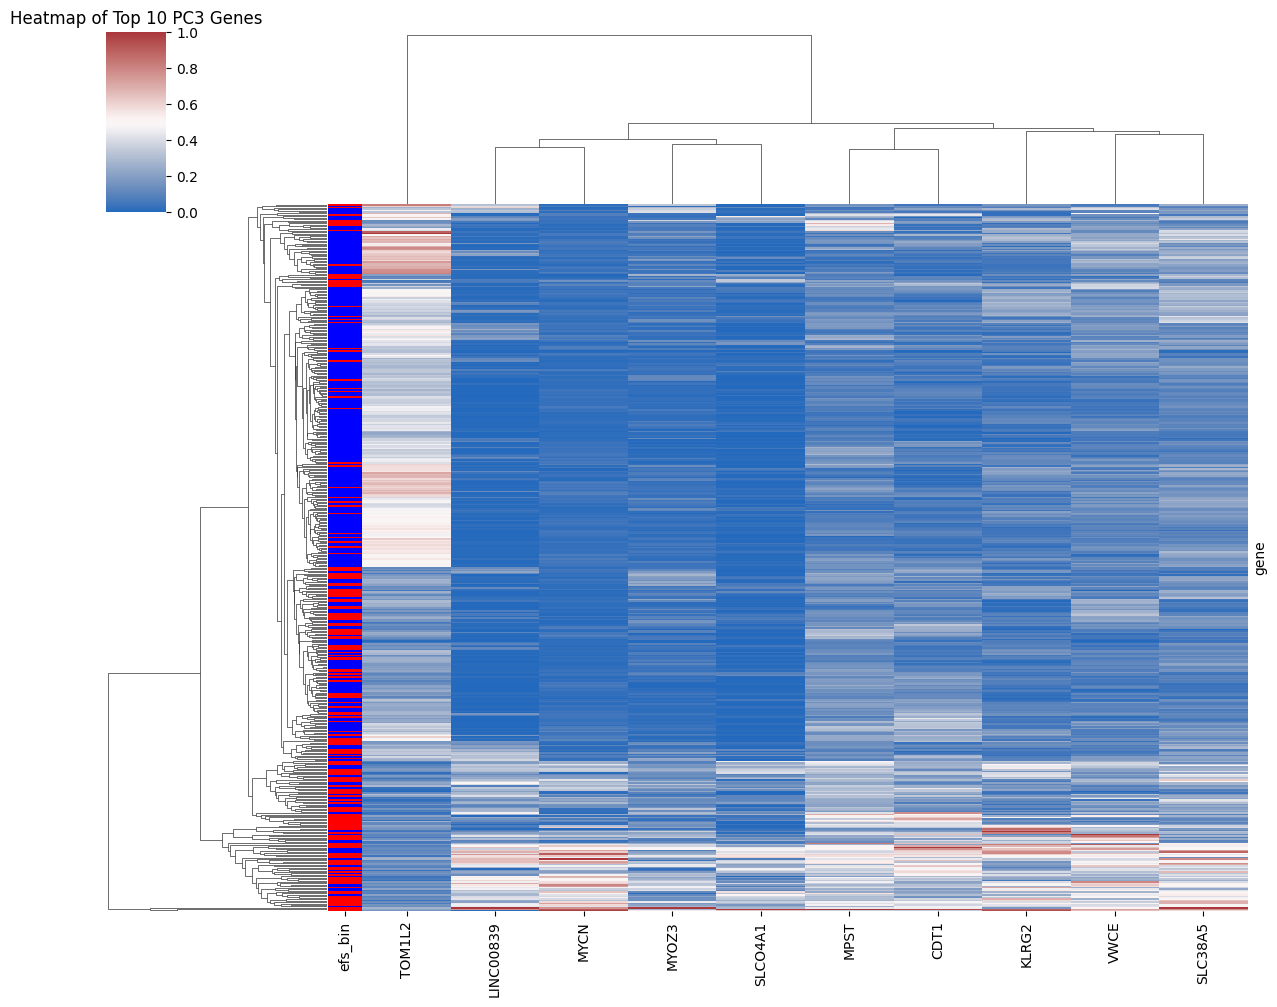

In [ ]:
plot_heatmap_for_pc('efs_bin', "event", "no_event")

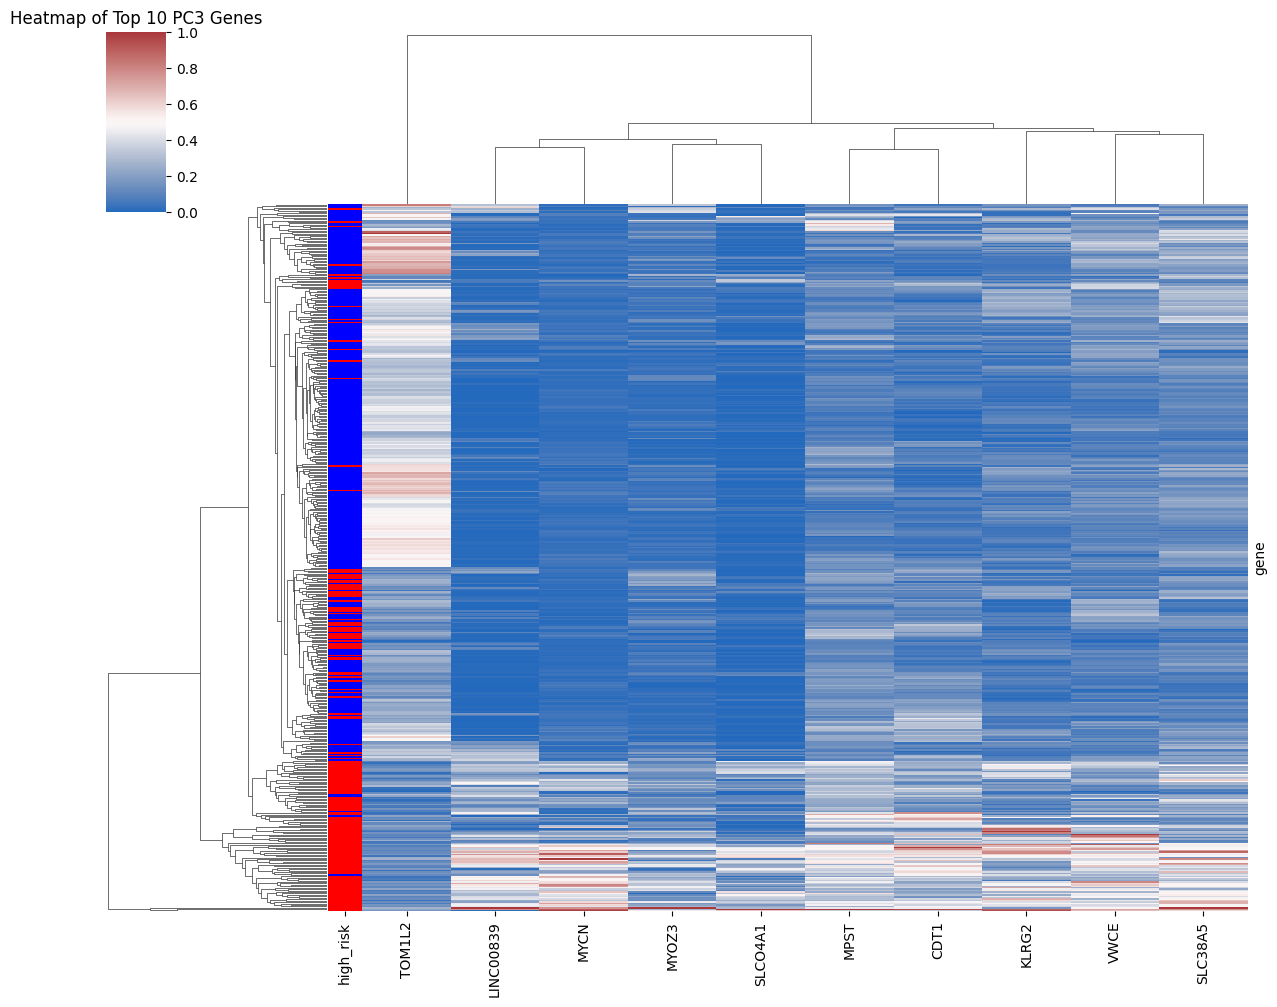

In [ ]:
plot_heatmap_for_pc('high_risk', "yes", "no")

# This heatmap shows the expression levels of the top 30 genes contributing to PC3 across all samples, with samples grouped by their `high_risk` status (red = high risk, blue = not high risk). Here's what you can interpret:

----------

🔍 1. Clustering of Samples by Gene Expression

- The columns are genes, and the rows are samples.
- You see distinct clusters in the dendrogram at the top, suggesting that these genes separate samples into expression-based groups.
- These clusters may correlate with the `high_risk` status, as red (high risk) samples are grouped differently than blue ones.
----------

🔥 2. Association Between PC3 Genes and High Risk

- There is a clear visual pattern:
    - A block of red samples (high risk) shows higher expression (red color) of some genes on the right side of the heatmap.
    - Meanwhile, many blue samples (low risk) show lower expression (blue color) of those same genes.

This implies:

- PC3 separates samples partly based on high_risk status.
- The genes contributing to PC3 are likely biologically relevant to this clinical feature.
----------

🧬 3. Gene-Level Observations

- Certain genes like RPL37A, RPS27A, EIF3P5, etc. show increased expression in high-risk samples.
- These may be candidates for further investigation (e.g., differential expression analysis or survival association).
----------

📊 Conclusion

- The heatmap supports that PC3 captures variance strongly associated with the `high_risk` phenotype, consistent with your previous PC3 vs. metadata p-values.
- The top PC3 genes are likely involved in pathways active in high-risk tumors.

# 🚀 Heatmap for top genes (groups) associate to mycn_status (in PC3)



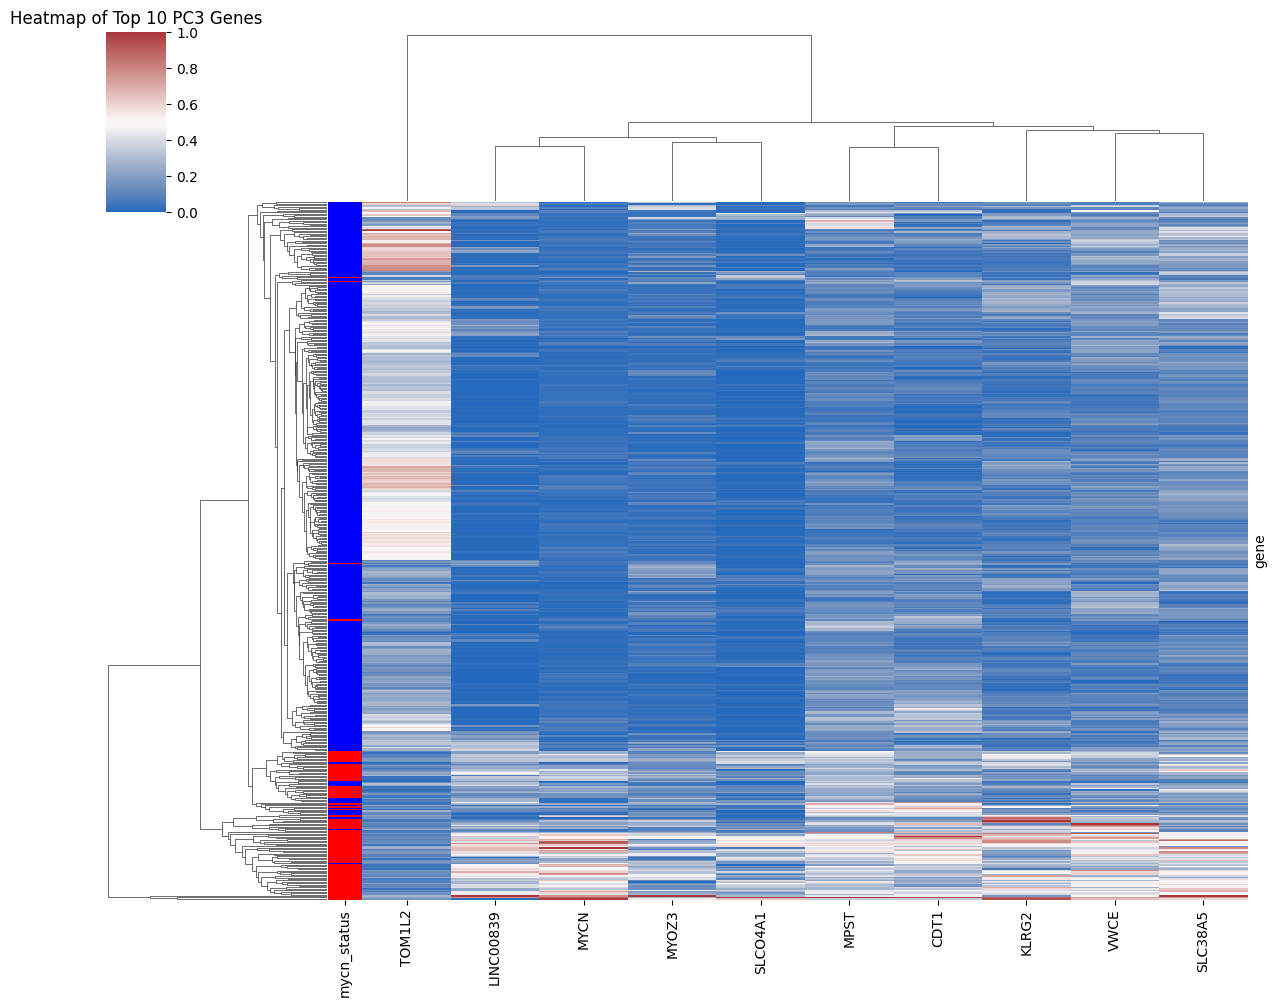

In [ ]:
plot_heatmap_for_pc('mycn_status', "mycn_amp", "mycn_nonamp")

# 🚀 Heatmap for top genes (groups) associate to d_fav_all (in PC3)



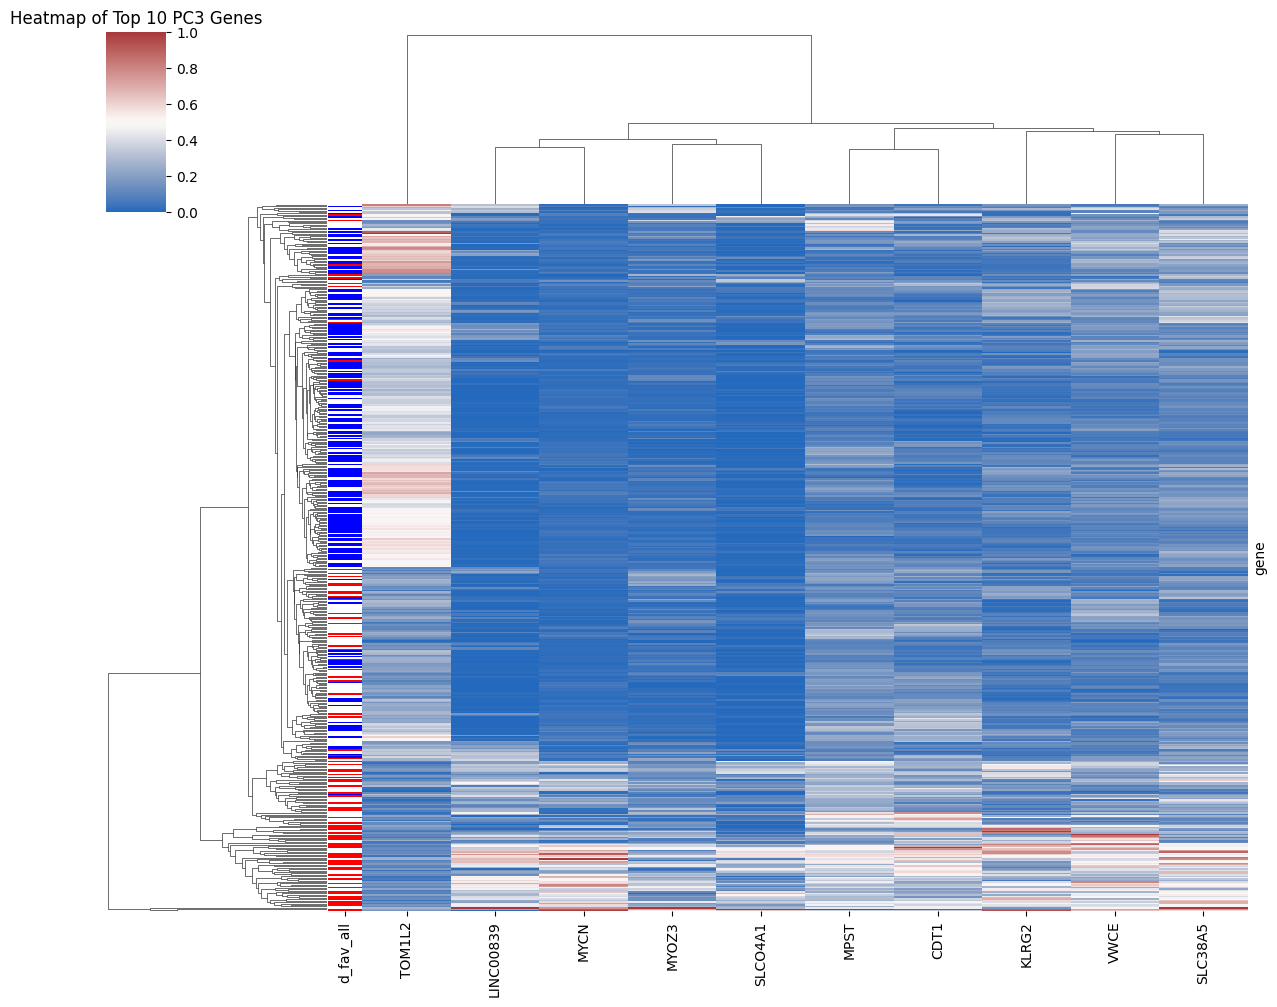

In [ ]:
plot_heatmap_for_pc( "d_fav_all", 'unfavorable', "favorable")

# based on these tops genes for PC3

In [ ]:
# Top PC3 genes
top_genes = 500

pc3_loadings = components.loc[pc_name]
top_positive = pc3_loadings.sort_values(ascending=False).head(top_genes)
top_negative = pc3_loadings.sort_values(ascending=True).head(top_genes)

# Save for GSEA or DE analysis
top_positive.to_csv("pc3_positive.rnk", sep="\t", header=False)
top_negative.to_csv("pc3_negative.rnk", sep="\t", header=False)

# ✅ Suggested GSEA Strategy

    Run GSEA (preranked) separately on:

      *  pc3_positive.rnk → genes contributing to positive PC3 direction.

      *  pc3_negative.rnk → genes contributing to negative PC3 direction.

## This will show:

  *  Which biological processes/pathways drive high PC3 scores (e.g. MYCN-amplified)

  * Which ones are enriched in low PC3 scores (e.g. non-MYCN)

# Run pre-ranked GSEA:

In [ ]:
!pip install gseapy

positive.rnk

In [ ]:
import gseapy as gp

# Perform preranked GSEA (e.g. with Reactome, KEGG, GO)
pre_res_positive = gp.prerank(
    rnk="pc3_positive.rnk",
    gene_sets="GO_Biological_Process_2021", #"KEGG_2021_Human",  # or "GO_Biological_Process_2021"
    outdir="gsea_pc3_pos",
    min_size=5, # 1 - 5
    max_size=100, # 100 - 2000
    permutation_num=100, # 100 - 10000, can increase for publication
    seed=42
)

# To see top pathways:
x = pre_res_positive.res2d.head(10)
x.to_csv("pre_res_positive_10.csv")
x


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,"regulation of transcription, DNA-templated (GO...",-0.377001,-0.765076,0.725,0.725,0.725,1/5,5.26%,CDT1


# negative.rnk


In [ ]:
# Perform preranked GSEA (e.g. with Reactome, KEGG, GO)
pre_res_negative = gp.prerank(
    rnk="pc3_negative.rnk",
    gene_sets="GO_Biological_Process_2021", #"KEGG_2021_Human",  # or "GO_Biological_Process_2021"
    outdir="gsea_pc3_neg",
    min_size=3, # 1 - 5
    max_size=100, # 100 - 2000
    permutation_num=100, # 100 - 10000, can increase for publication
    seed=42
)

# To see top pathways:
xn = pre_res_negative.res2d.head(10)
xn.to_csv("pre_negative_10.csv")
xn


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,DNA metabolic process (GO:0006259),-0.635098,-1.205827,0.133333,1.0,0.532609,2/4,13.16%,CDT1;DCTPP1
1,prerank,sulfur amino acid metabolic process (GO:0000096),-0.597003,-1.135462,0.309524,0.815047,0.630435,2/3,21.05%,MPST;AHCY
2,prerank,cellular protein localization (GO:0034613),-0.628571,-1.057029,0.431818,0.700104,0.717391,3/3,44.74%,MFN2;NPM1;STX12
3,prerank,regulation of transcription by RNA polymerase ...,0.462142,0.814309,0.759259,1.0,0.9,1/3,15.79%,MYCN
4,prerank,"regulation of transcription, DNA-templated (GO...",-0.377001,-0.765076,0.725,0.920846,0.902174,1/5,5.26%,CDT1
5,prerank,sulfur compound biosynthetic process (GO:0044272),-0.374913,-0.674081,0.804348,0.855799,0.956522,1/3,7.89%,MPST
6,prerank,regulation of translation (GO:0006417),0.371429,0.626554,0.840909,0.892388,0.95,3/3,65.79%,PUS7;TRAP1;NPM1


# GSEA 名詞解釋

| Column | Meaning |

| `Name` | The method used: `prerank` means you ran GSEA on a ranked list of genes. |

| `Term` | The name of the gene set (e.g., GO term, KEGG pathway). |

| `ES` (Enrichment Score) | Indicates whether genes from the gene set are enriched at the top (positive ES) or bottom (negative ES) of your ranked list. |

| `NES` (Normalized ES) | ES normalized by gene set size. Allows comparison across gene sets. |

| `NOM p-val` (Nominal p-value) | Raw significance of the enrichment score. |

| `FDR q-val` | Adjusted p-value accounting for multiple testing (False Discovery Rate). |

| `FWER p-val` | Family-Wise Error Rate (more conservative than FDR). |

| `Tag %` | Percentage of genes in the gene set that were actually found in your ranked list and contributed to the ES. |

| `Gene %` | Proportion of your ranked list that contributed to the enrichment signal. |

| `Lead_genes` | Genes most strongly contributing to the enrichment score. |

